In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random,os,glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten , MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img ,array_to_img

In [ ]:
dir_path = '/content/drive/MyDrive/Garbage classification'

In [ ]:
# test size ve Label Etiiketi Değerlerinin Belirlenmesi

target_size = (224,224)

waste_labels = {'cardboard': 0, 'glass':1,'metal':2,'paper':3,'plastic':4,'trash':5}

In [ ]:
# Görselleri okuma fonksiyonu

def load_datasets(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur

  Parametreler:

  path: Görsellerin bulunduğu dizini ifade eder

  Return:

  x: Görüntülere ait matris bilgilerini tutar.

  labels: Görüntünün ait olduğu sınıf bilgisini tutan liste

  """

  x = []

  labels = []

  # Gönderdiğimiz pathdeki görünüleri listeleyip sıralankatadır

  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:

    # Belirtilen pathdeki görüntüler openCv kütüphanesi ile okunur

    img = cv2.imread(image_path)

    # okunan görüntüler target size a göre yeniden ölçeklendirilir

    img = cv2.resize(img,target_size)

    # ölçeklendirilen görüntü x listesine eklenir

    x.append(img)

    # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı  labelı temsil etmektedir

    label = image_path.split(os.path.sep)[-2]

    # Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen key değerine karşılık değeri alınrak label oluşturulur

    labels.append(waste_labels[label])

  
  # Veri seti random bir şekilde karıştırlır 

  x, labels = shuffle(x, labels, random_state=42)

  # Boyut ve sınıf bilgisini raporlanmaktadır
  print(f"X boyutu:,{np.array(x).shape}")
  print(f"Labels sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")


  return x, labels

In [ ]:
x, labels = load_datasets(dir_path)

X boyutu:,(2527, 224, 224, 3)
Labels sınıf sayısı: 6 Gözlem sayısı: 2527


In [ ]:
input_shape = (np.array(np.array(x[0]).shape[1]), np.array(x[0]).shape[1], 3)
print(input_shape)

(array(224), 224, 3)


In [ ]:
def visualize_img(image_batch, label_batch):
  """

  Veri seti içerisinden görüntü görsellestirir.

  Parametreler:

  image_batch: Görüntülere ait matris bilgilerini tutar

  label_batch: Görüntünün ait olduğu sınıf bilgisini tutar

  """

  plt.figure(figsize=(10,10))

  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n] == 1][0].title())
    plt.axis('off')

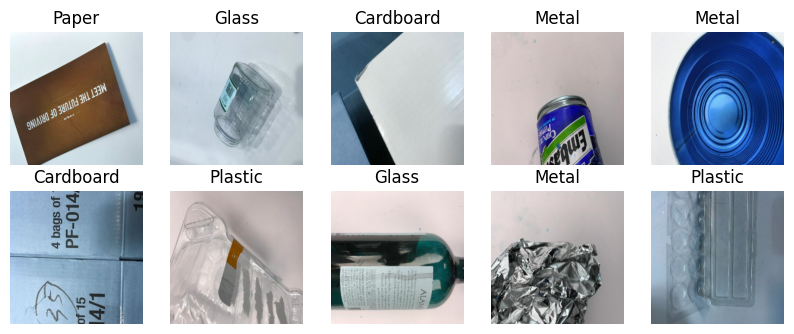

In [ ]:
visualize_img(x, labels)

## Veriyi Hazırlamak(Data Preparation)
## Data Augmentation

In [ ]:

# Train veri seti için bir generator tanımlıyoruz
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range =0.1,
                           zoom_range = 0.1,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

# Test veri seti için bir generator tanımlıyoruz
test = ImageDataGenerator(rescale = 1/255,
                          validation_split=0.1)

In [ ]:
train_generator = train.flow_from_directory(directory= dir_path,
                                            target_size = (target_size),
                                            class_mode = 'categorical',
                                            subset='training')

test_generator = test.flow_from_directory(directory= dir_path,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = 'categorical',
                                          subset = 'validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


## 4)Modelleme(Modeling)

## 4.1) Sıfırdan CNN Modeli Kurma

- Sequemtial
- Evrişim katmanı(Convulution Layer, Conv2D)
- Havuzlama Katmanı (Pooling Layer)
- Aktivasyon Fonksiyonu Katmanı (Activation Layer)
- Flattening Katmanı 
- Dense Katmanı
- Dropout Katmanı

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size =(3,3),padding='same',input_shape = (input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))
model.add(Conv2D(filters=64, kernel_size =(3,3),padding='same',input_shape = (input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))
model.add(Conv2D(filters=32, kernel_size =(3,3),padding='same',input_shape = (input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))

model.add(Flatten())

model.add(Dense(units=64 ,activation = 'relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(units=32 ,activation = 'relu'))
model.add(Dropout(rate = 0.2))

model.add(Dense(units=6 ,activation = 'softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience = 50,  verbose = 1, mode = 'min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor = 'val_loss', mode = 'min', save_best_only=True, save_weights_only=False ,verbose=1)]

## Modelin Eğitilmesi

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data = test_generator,
                              callbacks = callbacks,
                              workers = 4,
                              steps_per_epoch = 2276//32,
                              validation_steps = 251//32)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.7827 - precision: 0.2167 - recall: 0.0058 - acc: 0.2308
Epoch 1: val_loss improved from inf to 1.65891, saving model to mymodel.h5
71/71 [==============================] - 364s 5s/step - loss: 1.7827 - precision: 0.2167 - recall: 0.0058 - acc: 0.2308 - val_loss: 1.6589 - val_precision: 0.5000 - val_recall: 0.0040 - val_acc: 0.2470
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.6424 - precision: 0.5929 - recall: 0.0299 - acc: 0.3079
Epoch 2: val_loss improved from 1.65891 to 1.49367, saving model to mymodel.h5
71/71 [==============================] - 342s 5s/step - loss: 1.6424 - precision: 0.5929 - recall: 0.0299 - acc: 0.3079 - val_loss: 1.4937 - val_precision: 0.7500 - val_recall: 0.1195 - val_acc: 0.3426
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.5181 - precision: 0.7302 - recall: 0.1025 - acc: 0.3632
Epoch 3: val_loss improved from 1.49367 to 1.44379, saving mo

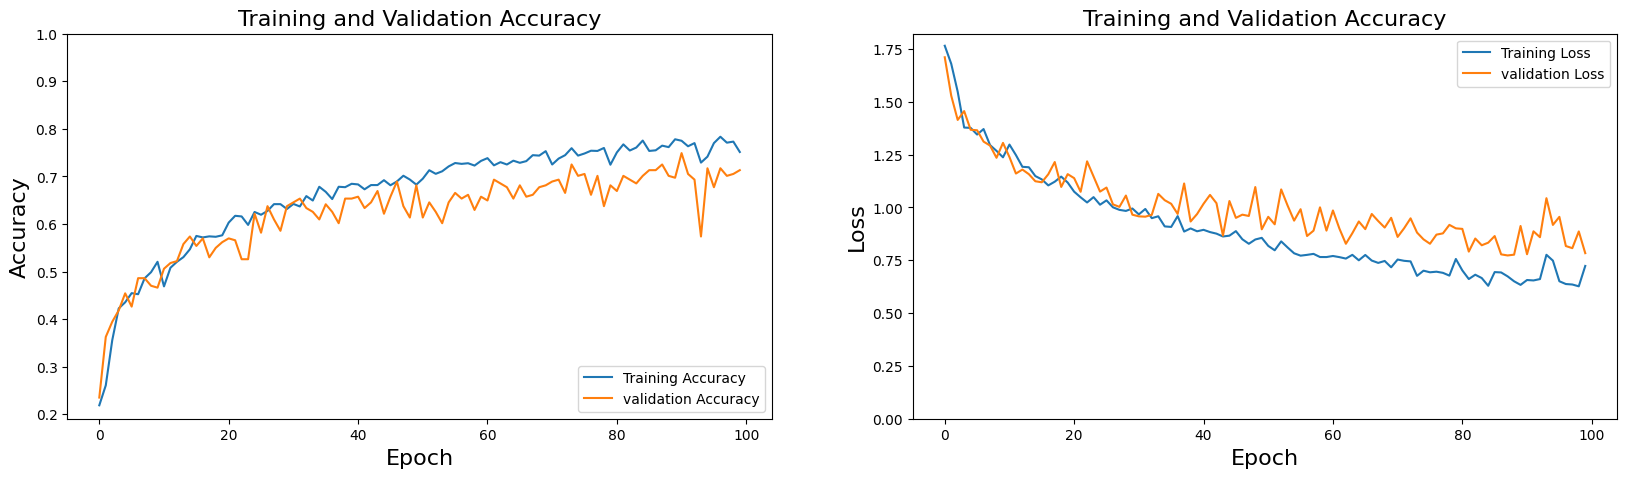

In [ ]:
# -------------------
# Accuracy Grafiği
# -------------------

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

# -------------------
# Loss Grafiği
# -------------------


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Accuracy', fontsize=16)
plt.show()

In [ ]:

loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.7837 - precision_1: 0.8187 - recall_1: 0.6295 - acc: 0.7131


In [ ]:
print("\nTest accuracy: %.lf%% "% (100.0*acc))
print("\nTest Loss: %.lf%% "% (100.0*loss))
print("\nTest precision: %.lf%% "% (100.0*precision))
print("\nTest recall: %.lf%% "% (100.0*recall))


Test accuracy: 71% 

Test Loss: 78% 

Test precision: 82% 

Test recall: 63% 


In [ ]:
## classification Report

x_test, y_test = test_generator.next()
y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

target_names = list(waste_labels.keys())

print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test,y_pred)

def plot_conf_matrix(cm,classes,
                     normalize=False,
                     title='Confusion Matrix',
                     cmap=plt.cm.Blues):
  
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'

  """

  if normalize:
    cm = cm.astype('fload') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arrange(len(classes))
  plt.xticks(tick_marks, classes, rotation=4)
  plt.yticks(ticks_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i, j in itertools.pruduct(range(cm.shape[0])), range(cm.shape[1]):
    plt.text(j,i, format(cm[i, j], fmt), 
             horizontalalignment="center",
             color = 'white' if cm[i, j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label', fontweight = "bold")
  plt.ylabel('Predicted Label' , fontweight = "bold")

In [ ]:
plot_conf_matrix(cm,waste_labels.keys(),
                 title="Confusion Matrix",
                 cmap = plt.cm.OrRd)

In [ ]:
def model_testing(path):
  """ 
  Görseldeki bulunduğu dizindeki görüntüyü okuyup model aracılığı ile hangi sınıfa ait olduğuna dair tahmin gerçekleştirdik

  Parametreler:

  path: Görsellerin bulundğu dizini ifade eder.

  Return:

  img: Görüntü

  p: Tahmin olasılıkları

  predicted_class: Tahmin Sınıfı

  """

  img = image.load_img(path, target_size= (taget_size))
  img = image.img_to_array(img, dtype= np.uint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class


img1, p1 , predicted_class1 = model_testing('/content/drive/MyDrive/Garbage classification/metal/metal1100.jpg')
img2, p2 , predicted_class2 = model_testing('/content/drive/MyDrive/Garbage classification/glass/glass105.jpg')
img3, p3 , predicted_class3 = model_testing('/content/drive/MyDrive/Garbage classification/cardboard/cardboard103.jpg')
img4, p4 , predicted_class4 = model_testing('/content/drive/MyDrive/Garbage classification/paper/paper106.jpg')

plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability"+ str(np.max(p1[0], axis=-1)) + "\n" +"Predicted Class: " +str(waste_labels[predicted_class1]))
plt.imshow(img1)

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title("Maximum Probability"+ str(np.max(p2[0], axis=-1)) + "\n" +"Predicted Class: " +str(waste_labels[predicted_class2]))
plt.imshow(img2)

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title("Maximum Probability"+ str(np.max(p3[0], axis=-1)) + "\n" +"Predicted Class: " +str(waste_labels[predicted_class3]))
plt.imshow(img3)

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title("Maximum Probability"+ str(np.max(p4[0], axis=-1)) + "\n" +"Predicted Class: " +str(waste_labels[predicted_class4]))
plt.imshow(img4)